In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
import tilemapbase

In [3]:
data = pd.read_csv('prepared_amsterdam_rent.csv')

In [23]:
yelp = pd.read_csv('./data/yelp_businesses.csv')

In [25]:
data.city.value_counts()

amsterdam                  15586
haarlem                     2130
amstelveen                  1255
zaandam                      788
hoofddorp                    765
diemen                       463
weesp                        379
heemstede                    286
nieuw-vennep                 273
zwanenburg                   245
aalsmeer                     231
badhoevedorp                 171
uithoorn                     166
ouderkerk-aan-de-amstel      110
bloemendaal                  100
duivendrecht                  56
Name: city, dtype: int64

In [26]:
#data = data[data['city']=='amsterdam']

In [27]:
data['pps'] = data['price']/data['surface']

In [28]:
ranks = {}
for t in data.type.unique():
    for pt in data.postType.unique():
        df = data[(data['type']==t)&(data['postType']==pt)]
        if len(df) > 0:
            ranks[(t,pt)] = df['pps'].rank()
            ranks[(t,pt)]=(ranks[(t,pt)]-ranks[(t,pt)].min())/(ranks[(t,pt)].max()-ranks[(t,pt)].min())

In [29]:
data['ppsRank'] = 0
for k in ranks:
    data.loc[ranks[k].index,'ppsRank'] = ranks[k]

In [30]:
buurten = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='cbs_buurten_2021')
wijken = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='cbs_wijken_2021')
gemeenten = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='gemeenten2021')

In [31]:
gdata = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
gdata = gdata.set_crs('EPSG:4326')

In [63]:
yelp = yelp[(yelp['latitude']>52.15)&(yelp['latitude']<52.5)&
    (yelp['longitude']>4.45)&(yelp['longitude']<5.2)]

In [64]:
gyelp = gpd.GeoDataFrame(yelp, geometry=gpd.points_from_xy(yelp.longitude, yelp.latitude))
gyelp = gyelp.set_crs('EPSG:4326')

In [33]:
buurten = buurten[['gemeentenaam','buurtnaam','geometry']].copy()
buurten['buurtnaam'] = buurten['buurtnaam'].str.strip().replace('',np.nan)
buurten = buurten.dropna()
buurten = buurten.to_crs('EPSG:4326')

In [34]:
wijken = wijken[['gemeentenaam','wijknaam','geometry']].copy()
wijken['wijknaam'] = wijken['wijknaam'].str.strip().replace('',np.nan)
wijken = wijken.dropna()
wijken = wijken.to_crs('EPSG:4326')

In [35]:
gemeenten = gemeenten[['gemeentenaam','geometry']].copy()
gemeenten['gemeentenaam'] = gemeenten['gemeentenaam'].str.strip().replace('',np.nan)
gemeenten = gemeenten.dropna()
gemeenten = gemeenten.to_crs('EPSG:4326')

In [36]:
gdata = gpd.sjoin(gdata, gemeenten, predicate='within').drop(columns='index_right')
gdata = gpd.sjoin(gdata, wijken, predicate='within').drop(columns='index_right')
gdata = gpd.sjoin(gdata, buurten, predicate='within').drop(columns='index_right')

In [38]:
gdata['ppsRank'] = gdata['ppsRank'].astype('float')

<AxesSubplot:>

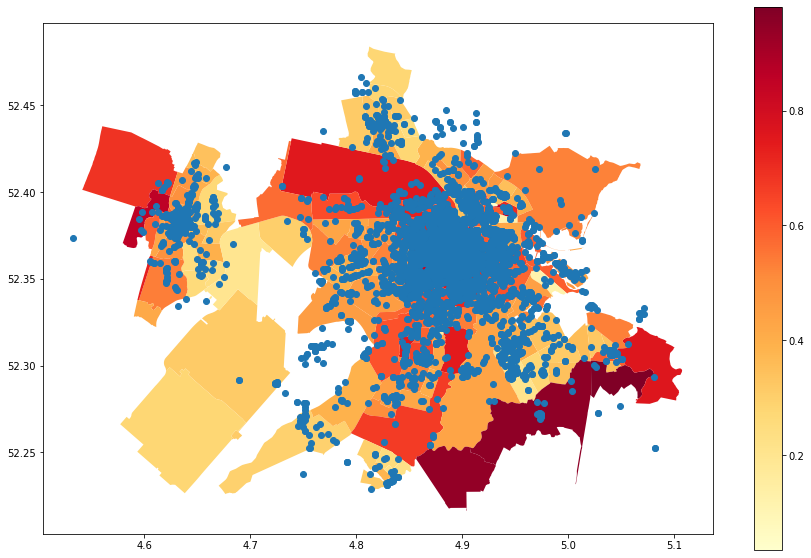

In [65]:
fig, ax = plt.subplots(figsize=(15, 10))
wijken.set_index(['wijknaam','gemeentenaam']).join(gdata.groupby(['wijknaam','gemeentenaam'])['ppsRank'].median(),how='inner').plot(column='ppsRank',cmap='YlOrRd',legend=True,ax=ax)
gyelp.plot(ax=ax)

<AxesSubplot:>

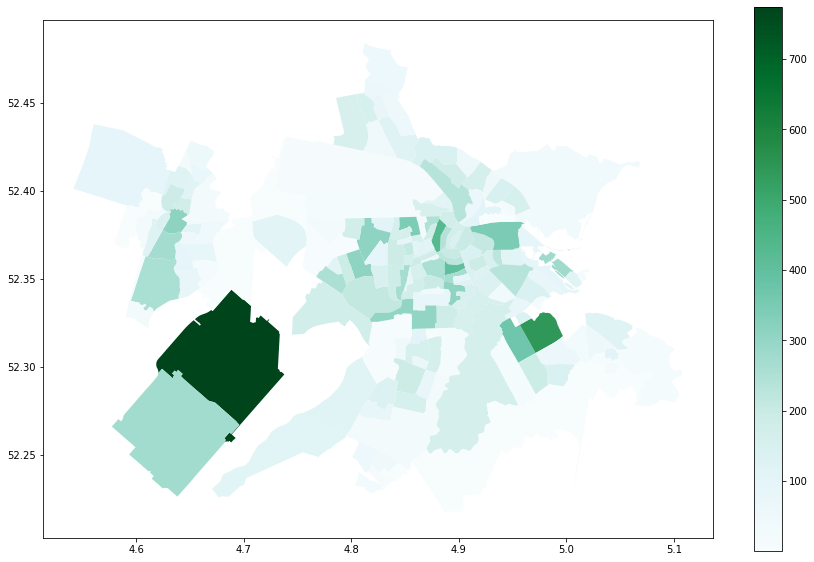

In [40]:
wijken.set_index(['wijknaam','gemeentenaam']).join(gdata.groupby(['wijknaam','gemeentenaam'])['ppsRank'].count(),how='inner').plot(column='ppsRank',cmap='BuGn',figsize=(15, 10),legend=True)

<AxesSubplot:>

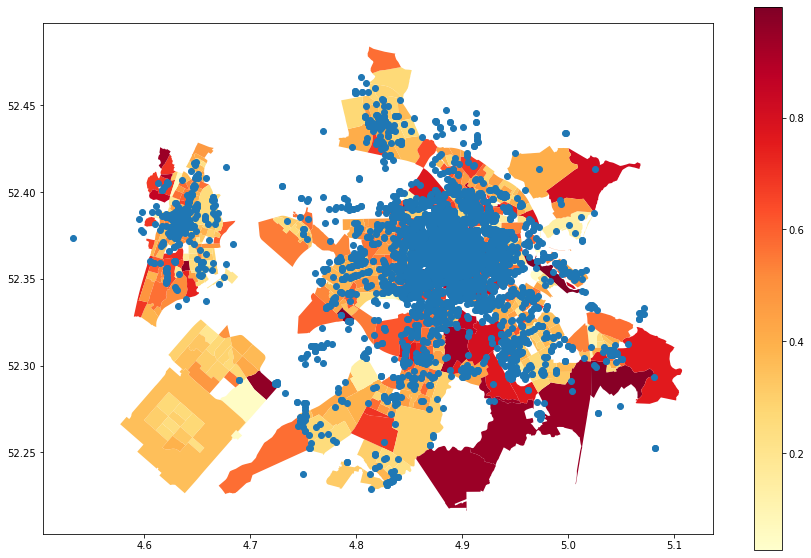

In [66]:
fig, ax = plt.subplots(figsize=(15, 10))
buurten.set_index(['buurtnaam','gemeentenaam']).join(gdf.groupby(['buurtnaam','gemeentenaam'])['ppsRank'].median(),how='inner').plot(column='ppsRank',cmap='YlOrRd',ax=ax,legend=True)
gyelp.plot(ax=ax)

<AxesSubplot:>

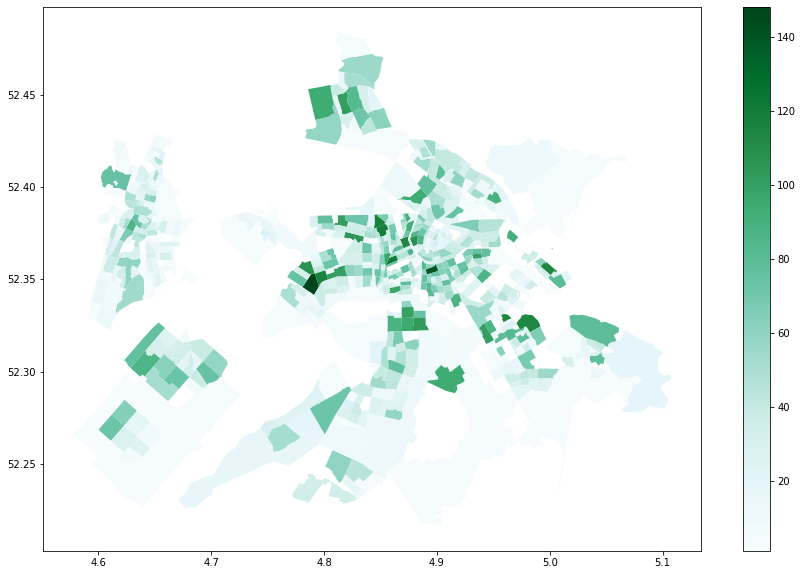

In [20]:
buurten.set_index(['buurtnaam','gemeentenaam']).join(gdf.groupby(['buurtnaam','gemeentenaam'])['ppsRank'].count(),how='inner').plot(column='ppsRank',cmap='BuGn',figsize=(15, 10),legend=True)

In [22]:
gdf.groupby(['buurtnaam','gemeentenaam'])['ppsRank'].count().sort_values()

buurtnaam              gemeentenaam  
Halfweg                Haarlemmermeer      1
Bloemenbuurt           Haarlem             1
Blauwe Zand            Amsterdam           1
Flevopark              Amsterdam           1
Zuiderhout             Zaanstad            1
                                        ... 
Bosleeuw               Amsterdam         117
Erasmusparkbuurt West  Amsterdam         119
Cremerbuurt West       Amsterdam         121
Sarphatiparkbuurt      Amsterdam         140
De Aker Oost           Amsterdam         148
Name: ppsRank, Length: 701, dtype: int64

In [21]:
gdf[gdf['buurtnaam']=='Waterloopleinbuurt']

,source,city,postcode,type,price,surface,rooms,latitude,longitude,postType,pps,ppsRank,geometry,gemeentenaam_left,gemeentenaam_right,wijknaam,gemeentenaam,buurtnaam
280,funda,amsterdam,1011PW,house,5500.0,125.0,4.0,52.366212,4.901867,Rent,44.000000,0.993421,POINT (4.90187 52.36621),Amsterdam,Amsterdam,Nieuwmarkt/Lastage,Amsterdam,Waterloopleinbuurt
803,funda,amsterdam,1011PG,apartment,2100.0,70.0,3.0,52.367457,4.902367,Rent,30.000000,0.787379,POINT (4.90237 52.36746),Amsterdam,Amsterdam,Nieuwmarkt/Lastage,Amsterdam,Waterloopleinbuurt
1800,pararius,amsterdam,1011PW,house,5500.0,125.0,4.0,52.366212,4.901867,Rent,44.000000,0.993421,POINT (4.90187 52.36621),Amsterdam,Amsterdam,Nieuwmarkt/Lastage,Amsterdam,Waterloopleinbuurt
1896,pararius,amsterdam,1011PG,apartment,2100.0,70.0,3.0,52.367457,4.902367,Rent,30.000000,0.787379,POINT (4.90237 52.36746),Amsterdam,Amsterdam,Nieuwmarkt/Lastage,Amsterdam,Waterloopleinbuurt
3989,pararius,amsterdam,1011RK,house,150000.0,187.0,4.0,52.366245,4.902406,Buy,802.139037,0.212834,POINT (4.90241 52.36624),Amsterdam,Amsterdam,Nieuwmarkt/Lastage,Amsterdam,Waterloopleinbuurt
5095,funda,amsterdam,1011RK,house,1500000.0,187.0,4.0,52.366245,4.902406,Buy,8021.390374,0.904856,POINT (4.90241 52.36624),Amsterdam,Amsterdam,Nieuwmarkt/Lastage,Amsterdam,Waterloopleinbuurt
6131,funda,amsterdam,1011NV,apartment,500000.0,58.0,2.0,52.369069,4.901073,Buy,8620.689655,0.890942,POINT (4.90107 52.36907),Amsterdam,Amsterdam,Nieuwmarkt/Lastage,Amsterdam,Waterloopleinbuurt
9683,funda,amsterdam,1011RK,apartment,1500000.0,187.0,4.0,52.366245,4.902406,Buy,8021.390374,0.827954,POINT (4.90241 52.36624),Amsterdam,Amsterdam,Nieuwmarkt/Lastage,Amsterdam,Waterloopleinbuurt
10735,funda,amsterdam,1011PW,apartment,5500.0,125.0,4.0,52.366212,4.901867,Rent,44.000000,0.978302,POINT (4.90187 52.36621),Amsterdam,Amsterdam,Nieuwmarkt/Lastage,Amsterdam,Waterloopleinbuurt
13940,pararius,amsterdam,1011NS,apartment,64000.0,84.0,3.0,52.368722,4.902685,Buy,761.904762,0.139381,POINT (4.90268 52.36872),Amsterdam,Amsterdam,Nieuwmarkt/Lastage,Amsterdam,Waterloopleinbuurt


In [201]:
gdf

,source,city,postcode,type,price,surface,rooms,latitude,longitude,postType,pps,ppsRank,geometry,gemeentenaam_left,gemeentenaam_right,wijknaam,gemeentenaam,buurtnaam
0,kamernet,amsterdam,1103SE,apartment,3120.0,120.0,3.0,52.322331,4.981073,Rent,26.000000,0.637788,POINT (4.98107 52.32233),Amsterdam,Amsterdam,"Bijlmer Oost (E,G,K)",Amsterdam,Grunder/Koningshoef
6,kamernet,amsterdam,1103SC,room,700.0,18.0,1.0,52.323896,4.978770,Rent,38.888889,0.338993,POINT (4.97877 52.32390),Amsterdam,Amsterdam,"Bijlmer Oost (E,G,K)",Amsterdam,Grunder/Koningshoef
1547,pararius,amsterdam,1104DB,apartment,1250.0,35.0,2.0,52.320184,4.981254,Rent,35.714286,0.921637,POINT (4.98125 52.32018),Amsterdam,Amsterdam,"Bijlmer Oost (E,G,K)",Amsterdam,Grunder/Koningshoef
3256,pararius,amsterdam,1104DC,apartment,42500.0,90.0,4.0,52.320079,4.982193,Buy,472.222222,0.045271,POINT (4.98219 52.32008),Amsterdam,Amsterdam,"Bijlmer Oost (E,G,K)",Amsterdam,Grunder/Koningshoef
5017,funda,amsterdam,1103SE,house,495000.0,117.0,5.0,52.322331,4.981073,Buy,4230.769231,0.400530,POINT (4.98107 52.32233),Amsterdam,Amsterdam,"Bijlmer Oost (E,G,K)",Amsterdam,Grunder/Koningshoef
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12183,funda,zwanenburg,1161XL,house,350000.0,99.0,5.0,52.379823,4.739932,Buy,3535.353535,0.268694,POINT (4.73993 52.37982),Haarlemmermeer,Haarlemmermeer,Zwanenburg,Haarlemmermeer,Zwanenburg Zuidwest
12222,funda,zwanenburg,1161XL,apartment,350000.0,99.0,5.0,52.379823,4.739932,Buy,3535.353535,0.257083,POINT (4.73993 52.37982),Haarlemmermeer,Haarlemmermeer,Zwanenburg,Haarlemmermeer,Zwanenburg Zuidwest
12123,pararius,zwanenburg,2061CD,apartment,1500.0,60.0,1.0,52.404428,4.620438,Rent,25.000000,0.593927,POINT (4.62044 52.40443),Bloemendaal,Bloemendaal,Wijk 00 Bloemendaal,Bloemendaal,Bloemendaal
12133,pararius,zwanenburg,2106CJ,apartment,1495.0,70.0,2.0,52.359034,4.614176,Rent,21.357143,0.382891,POINT (4.61418 52.35903),Heemstede,Heemstede,Wijk 00 Heemstede-Centrum,Heemstede,Zandvoortselaan en Berkenrode en omgeving


In [202]:
gdf.groupby(['gemeentenaam','wijknaam','buurtnaam'])['ppsRank'].count().sort_values()

gemeentenaam  wijknaam                   buurtnaam                   
Amsterdam     Tuindorp Buiksloot         Blauwe Zand                       1
Haarlem       Duinwijk                   Bloemenbuurt                      1
Amsterdam     Geuzenveld                 Eendrachtspark                    1
              Westelijk Havengebied      Alfa-driehoek                     1
Weesp         Zuid                       Zuid I                            1
                                                                        ... 
Amsterdam     Osdorp-Midden              Zuidwestkwadrant Osdorp Zuid    114
              Overtoomse Sluis           Cremerbuurt West                123
              Oude Pijp                  Sarphatiparkbuurt               127
              Middelveldsche Akerpolder  De Aker Oost                    142
              Nieuwmarkt/Lastage         Waterloopleinbuurt              352
Name: ppsRank, Length: 669, dtype: int64

<AxesSubplot:>

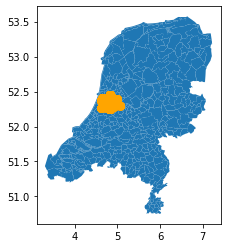

In [176]:
fig, ax = plt.subplots()
gemeenten.plot(ax=ax)
gdf.plot(ax=ax,color='orange')

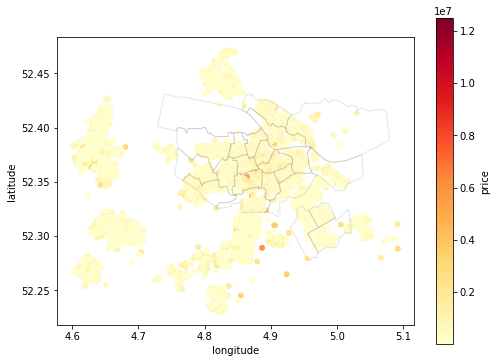

In [75]:
fig, ax = plt.subplots(figsize=(8,6))
data.plot(x='longitude',y='latitude',kind='scatter',c='price',
          colormap="YlOrRd",ax=ax)
city.plot(ax=ax, alpha=0.1, edgecolor="black", facecolor="white")
plt.show()

In [79]:
bounding_box = [data.longitude.min(), data.longitude.max(), data.latitude.min(), data.latitude.max()]

In [80]:
tilemapbase.start_logging()
tilemapbase.init(create=True)
extent = tilemapbase.extent_from_frame(city, buffer = 25)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

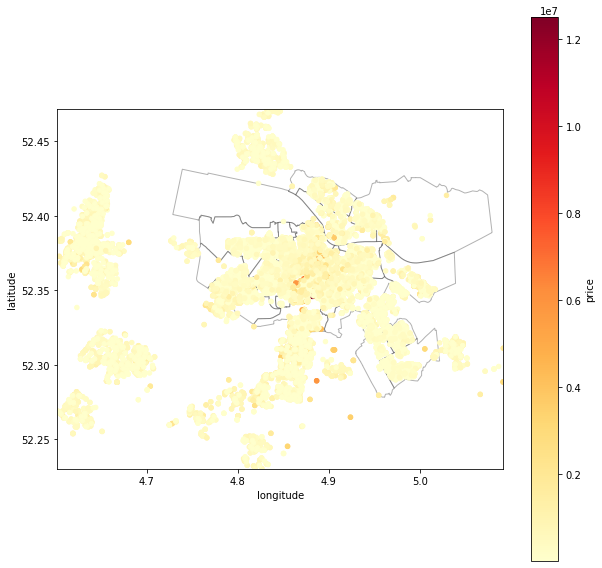

In [81]:
fig, ax = plt.subplots(figsize=(10,10))
plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000)
plotter.plot(ax)
ax.set_xlim(bounding_box[0], bounding_box[1])
ax.set_ylim(bounding_box[2], bounding_box[3])
city.plot(ax=ax, alpha=0.3, edgecolor="black", facecolor="white")
data.plot(x='longitude',y='latitude',kind='scatter',c='price',
          colormap="YlOrRd",ax=ax)
#ax.figure.savefig('./data/plot1.png', bbox_inches='tight')

In [16]:
kde.sample(1)

array([[ 5.35729296, 52.27216813]])

In [17]:
from sklearn.neural_network import MLPRegressor

In [54]:
Xtrain = np.array(data[['longitude','latitude']])

In [55]:
ytrain = np.array(data['price'])

In [57]:
regr = MLPRegressor(hidden_layer_sizes = (100,64), max_iter=500).fit(Xtrain, ytrain)

In [58]:
p = regr.predict(xy)

In [59]:
xy

array([[52.258922  ,  4.771238  ],
       [52.258922  ,  4.77186966],
       [52.258922  ,  4.77250132],
       ...,
       [52.468791  ,  5.08517268],
       [52.468791  ,  5.08580434],
       [52.468791  ,  5.086436  ]])

In [60]:
pred = pd.DataFrame(xy,columns=['latitude','longitude'])

In [61]:
pred['val'] = p

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

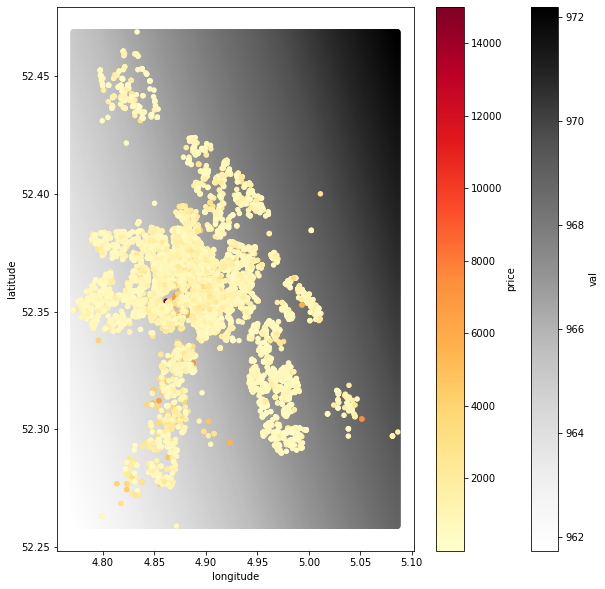

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
pred.plot(x='longitude',y='latitude',kind='scatter',c='val',ax=ax)
data.plot(x='longitude',y='latitude',kind='scatter',c='price',
          colormap="YlOrRd",ax=ax)

In [63]:
import 

ModuleNotFoundError: No module named 'tensorflow.python'

(array([6.650e+02, 4.064e+03, 2.333e+03, 1.254e+03, 4.870e+02, 1.660e+02,
        4.700e+01, 1.300e+01, 5.000e+00, 2.000e+00]),
 array([2.00000000e-02, 1.71608571e+01, 3.43017143e+01, 5.14425714e+01,
        6.85834286e+01, 8.57242857e+01, 1.02865143e+02, 1.20006000e+02,
        1.37146857e+02, 1.54287714e+02, 1.71428571e+02]),
 <BarContainer object of 10 artists>)

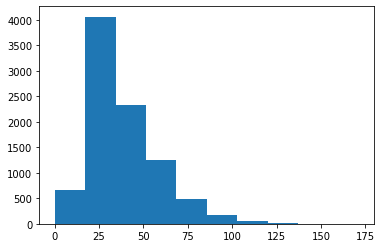

In [68]:
plt.hist(data['price']/data['surface'])